# Introduction

Top athletes are put to the ultimate test bi-yearly - competing at the Olympics amongst their highest competitors. Notoriously, new-talent athletes are introduced at this international event, and winning a medal solidifies their credibility as a top performer (Horne, 2016). 

According to Apollaro et al, younger athletes tend to show more success in sports such as taekwondo,due to their physical strength and weight (Apollaro, 2022). However, studies such as by Ford and Williams have demonstrated through experimentation that higher skill level that comes with age contributes to more awards in sports such as soccer (Ford, 2013) or skiing. 

This leads us to our question: Across the summer and winter Olympics, what is the mean age of first-time Olympic medal winners? To conduct this analysis, we will be filtering our dataset of winter and summer Olympic medallists to ensure we only count the age of their debut win towards the mean of the sample population using `age`, `season`, and `medals`. Additionally, we will be using standard deviation as our scale parameter. We will be generalizing age across sports and genders, and assuming that the age of peak performance is similar in all of them. This is because we aim to find the mean age of the average Olympian, regardless of the sport they’re associated with. We hypothesize that due to extraneous demands and reliance on the environment in winter sports, the skill and mental and physical strengths of older athletes will prove more advantageous in the winter compared to the summer.

# Preliminary Results

## Load Libraries

In [1]:
## code to get rid of warnings
defaultW <- getOption("warn") 
options(warn = -1) 
##

suppressPackageStartupMessages(library(tidyverse))
library(repr)
library(digest)
library(infer)
suppressPackageStartupMessages(library(gridExtra))
library(cowplot)
source("R/plotting.R")
source("R/display.R")

## Data Intake and Pre-Processing

First, we will read in the dataset. The code here assumes you've downloaded the dataset and placed them into a data folder. If you would like to run our code and follow along, please clone our GitHub repository [here](https://github.com/KevinSaigon/stat-201-project)

In [2]:
data <- read.csv(file = "data/athlete_events.csv")
# website says "Demonstrate that the dataset can be read from the web into R." - is local files okay? Ask on Monday

We will then do some pre-processing to get rid of any athlete whose age is is not known as well as filter out ones who did not win gold medals. 

The next step was then to only count first-time wins for multiple-time medal winners (i.e Michael Phelps). The code below essentially only keep the first occurrence of an athlete's ID, and since we sorted the dataframe by Year, this equates to the athlete's first time winning the gold medal.

In [3]:
processed_df <- data[order(data$Year),]  %>% 
    filter(!is.na(Age)) %>%    # get rid of NA/Age
    filter(!is.na(Medal)) %>%  # get rid of anyone who didn't win a medal either
    subset(select = c(ID, Name, Age, Season, Medal))

first_time_only <- processed_df[match(unique(processed_df$ID), processed_df$ID),] # only first time winners now, if they won a second time, it was excluded
    
head(first_time_only)

,ID,Name,Age,Season,Medal
,<int>,<chr>,<int>,<chr>,<chr>
1,12068,Arthur Charles Blake,24,Summer,Silver
2,12563,Conrad Helmut Fritz Bcker,25,Summer,Gold
4,12929,John Mary Pius Boland,25,Summer,Gold
6,16616,"Thomas Edmund ""Tom"" Burke",21,Summer,Gold
8,17492,Eugne Henri Callot,20,Summer,Silver
9,18785,Demetrius Emmanuel Casdagli,23,Summer,Silver


Next, we will split the dataset by their Season, the winter Olympics vs the summer Olympics

In [4]:
winter_df <- first_time_only %>% 
    filter(Season == "Winter")

summer_df <- first_time_only %>% 
    filter(Season == "Summer")

head(winter_df)
head(summer_df)

,ID,Name,Age,Season,Medal
,<int>,<chr>,<int>,<chr>,<chr>
1,391,Clarence John Abel,23,Winter,Silver
2,1341,Johan Petter hln (Andersson-),44,Winter,Silver
3,3872,William Harding Anderson,22,Winter,Bronze
4,4060,Georges Jules Andr,47,Winter,Bronze
5,5232,Thomas Alfred Arnold,22,Winter,Silver
6,5932,Alfred Aufdenblatten,26,Winter,Gold


,ID,Name,Age,Season,Medal
,<int>,<chr>,<int>,<chr>,<chr>
1,12068,Arthur Charles Blake,24,Summer,Silver
2,12563,Conrad Helmut Fritz Bcker,25,Summer,Gold
3,12929,John Mary Pius Boland,25,Summer,Gold
4,16616,"Thomas Edmund ""Tom"" Burke",21,Summer,Gold
5,17492,Eugne Henri Callot,20,Summer,Silver
6,18785,Demetrius Emmanuel Casdagli,23,Summer,Silver


## Calculations 

If we are assuming that this dataset is 100% accurate and thus represent that entire population of all Olympic participants, then we could consider the dataset a population, and thus uncertainty would be 0%. However, in reality, if we were trying to gather this dataset ourselves, it is extremely unlikely as well as unfeasible to collect so many data points. Realistically, we would take a sample of this population, so we will will take an initial sample of 1000

In [5]:
set.seed(42069)

winter_sample <- winter_df %>% 
    rep_sample_n(size = 1000, reps = 1) %>% 
    subset(select = -(replicate))

summer_sample <- summer_df %>% 
    rep_sample_n(size = 1000, reps = 1) %>% 
    subset(select = -(replicate))

head(winter_sample)

ID,Name,Age,Season,Medal
<int>,<chr>,<int>,<chr>,<chr>
85481,Michael Neumayer,31,Winter,Silver
25759,Vitaly Semyonovich Davydov,24,Winter,Gold
3951,Lina Marie Andersson,24,Winter,Gold
44916,Veikko Johannes Hakulinen,27,Winter,Gold
42073,Amlie Goulet-Nadon,19,Winter,Bronze
49094,Lukas Hofer,24,Winter,Bronze


From this, we can calculate our estimates of the mean for each season

In [6]:
winter_mean_estimate <- mean(winter_sample$Age)
summer_mean_estimate <- mean(summer_sample$Age)

cat("Winter Mean Estimate:", winter_mean_estimate, "\nSummer Mean Estimate:", summer_mean_estimate)

Winter Mean Estimate: 25.165 
Summer Mean Estimate: 25.078

## Sampling

Then, we'll perform bootstrapping or resampling with replacement to calculate uncertainty later on

In [7]:
set.seed(42069)

winter_bootstrap <- winter_sample %>% 
    rep_sample_n(size = 1000, reps = 200, replace = TRUE)

summer_bootstrap <- summer_sample %>% 
    rep_sample_n(size = 1000, reps = 200, replace = TRUE)


head(summer_bootstrap)

replicate,ID,Name,Age,Season,Medal
<int>,<int>,<chr>,<int>,<chr>,<chr>
1,59251,Ilias Khatzipavlis,23,Summer,Silver
1,26210,"Regina Constance ""Reggie"" de Jong",16,Summer,Bronze
1,63441,Andriy Kovalenko,21,Summer,Bronze
1,33767,Otto Fahr,19,Summer,Silver
1,69088,Melanie Leupolz,22,Summer,Gold
1,100141,Michael Reusch,22,Summer,Silver


Now, we will calculate the sample mean for each sample.

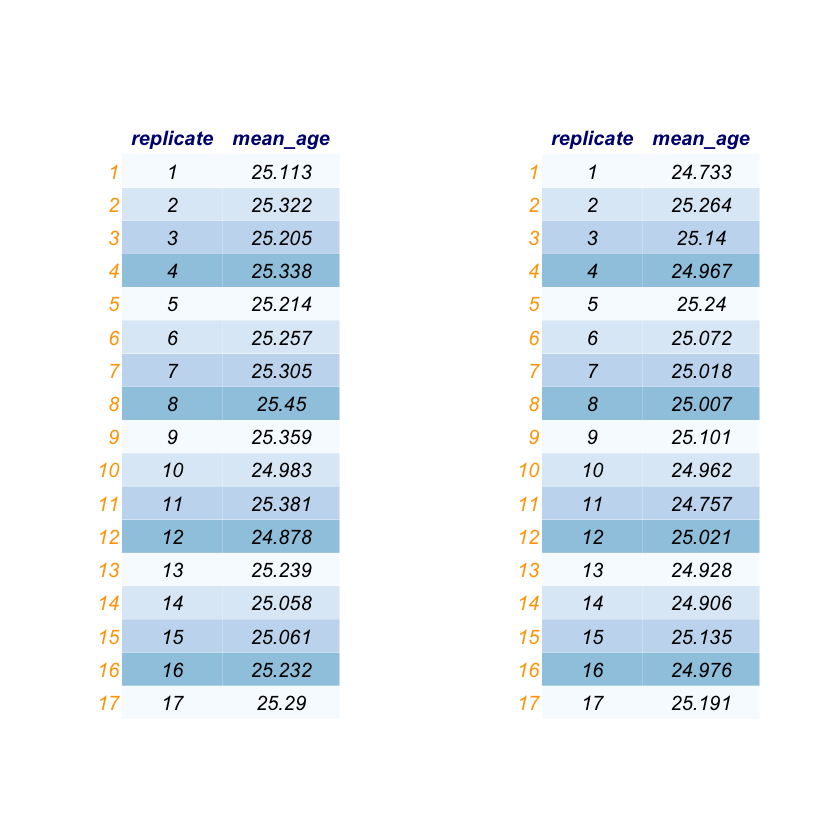

In [8]:
winter_resampled_means <- winter_bootstrap %>% 
    group_by(replicate) %>% 
    summarize(mean_age = mean(Age))

summer_resampled_means <- summer_bootstrap %>% 
    group_by(replicate) %>% 
    summarize(mean_age = mean(Age))

df_list = list(head(winter_resampled_means, 17), head(summer_resampled_means, 17))
table_render(df_list)

## Visualizations

Let's first remind ourselves of our calculated estimates

In [9]:
name <- c("Winter Mean Estimate", "Summer Mean Estimate")
values <- c(winter_mean_estimate, summer_mean_estimate)

tab <- data.frame(name, values)
tab

name,values
<chr>,<dbl>
Winter Mean Estimate,25.165
Summer Mean Estimate,25.078


In [10]:
winter_hist <- plot_histogram(winter_resampled_means, "mean_age", 0.1, TRUE) + 
    geom_vline(xintercept = winter_mean_estimate, color = "blue") + 
    labs(x="Mean Age", title="Bootstrap distribution of Mean Age for Winter Olympics")


In [11]:
summer_hist <- plot_histogram(summer_resampled_means, "mean_age", 0.1, TRUE) +
    geom_vline(xintercept = summer_mean_estimate, color = "blue") +
    labs(x="Mean Age", title="Bootstrap distribution of Mean Age for Summer Olympics")

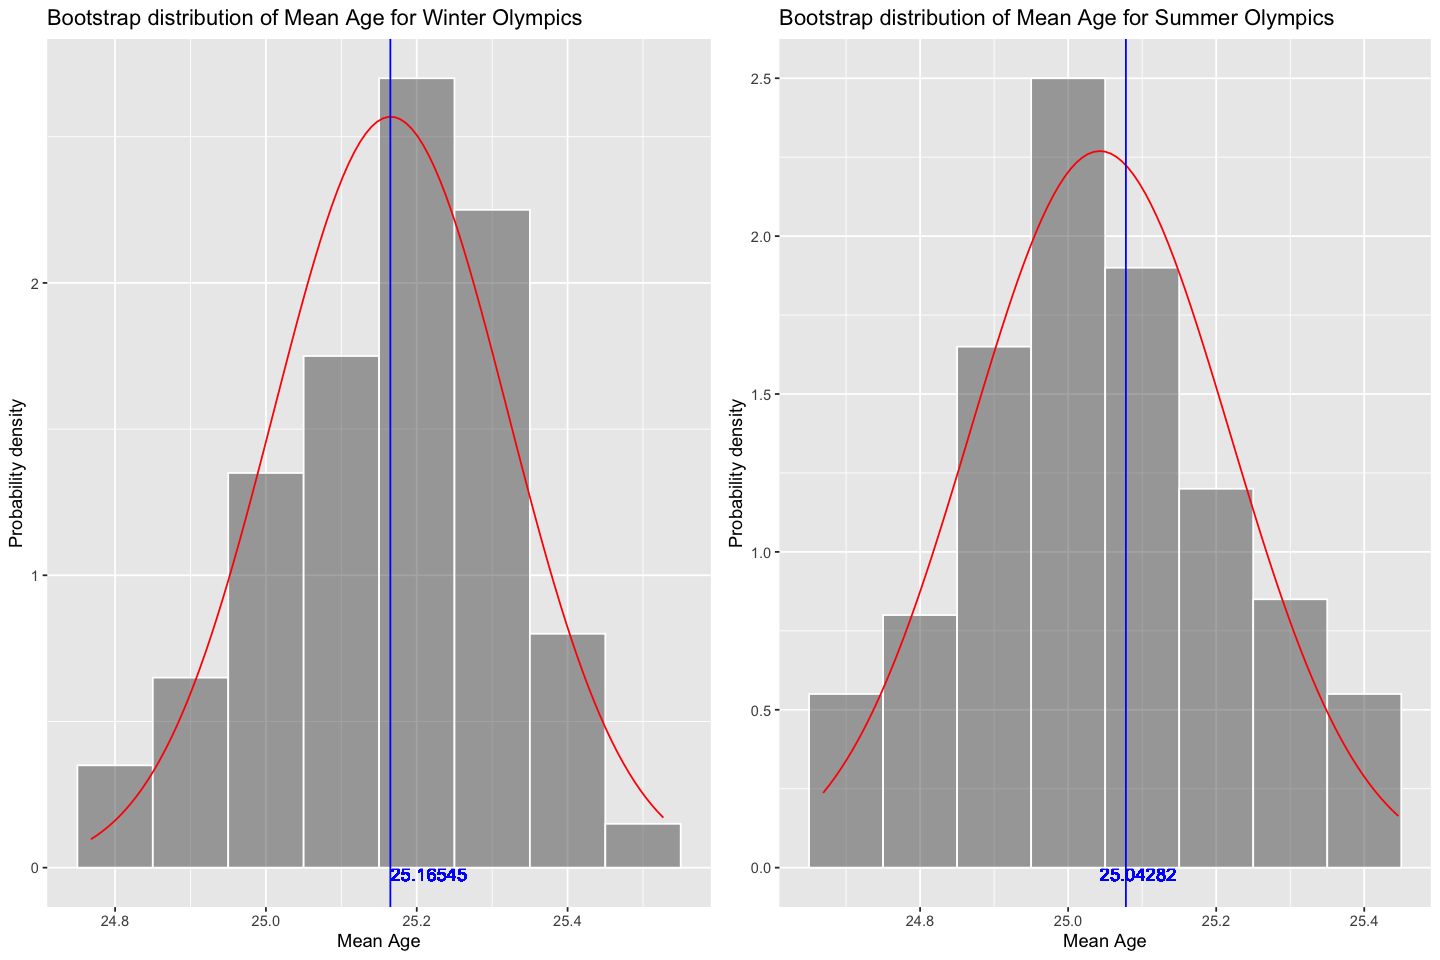

In [12]:
options(repr.plot.width=12, repr.plot.height=8)
plot_grid(winter_hist, summer_hist)

# Methods

This report is trustworthy because in pre-processing, we exclusively included examples that fit the criteria of our research question, i.e athletes that have won medals and whose ages are known. Our sample was conducted randomly, meaning it is representative of the Olympian population. Finally, the report is trustworthy because it concedes that there is uncertainty in our calculated mean ages. We will use our plan and preliminary results to find accurate estimates of the true ages, not the exact ages.

Our sampling distribution plots and point estimates are not sufficient to take to stakeholders because they do not illustrate the uncertainty in our calculations. We plan to calculate 95% confidence intervals of the mean age of first-time Olympic medalists in the Summer and Winter Olympics to take the sampling variation into account, and to conduct a t-test to see if the true average ages between the games are different.

Since our research suggests that higher age tends to correlate with higher skill level, and since Winter Olympic events generally seem to put more emphasis on skill than physical capability, we believe we will find a slightly higher average age for Winter Olympic medalists. 

Our results could be useful for Olympic recruiters, coaches, and athletes. If we find a large distinction in average age of first time medalists between the games, recruiters may put less emphasis on youth and more on skill level for, say, the Winter games. Additionally, athletes may feel less discouraged about their early career performance, and prioritize improvement with age. 

In the future, questions about the age differences between multi-winning medalists can be considered. If our research indicates that skill level is more important to Winter Olympians, maybe the difference in average ages of multi-winning medalists is even more distinct.


### T - Test

In [13]:
t.test(pull(summer_sample, Age),
       pull(winter_sample, Age),
       alternative = "two.sided",
       conf.level = 0.95)


	Welch Two Sample t-test

data:  pull(summer_sample, Age) and pull(winter_sample, Age)
t = -0.36866, df = 1958.1, p-value = 0.7124
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.5498184  0.3758184
sample estimates:
mean of x mean of y 
   25.078    25.165 


### Simulation-based hypothesis testing

[1] "P-value = 1"


lower_ci,upper_ci
<dbl>,<dbl>
-0.5494296,0.3763015


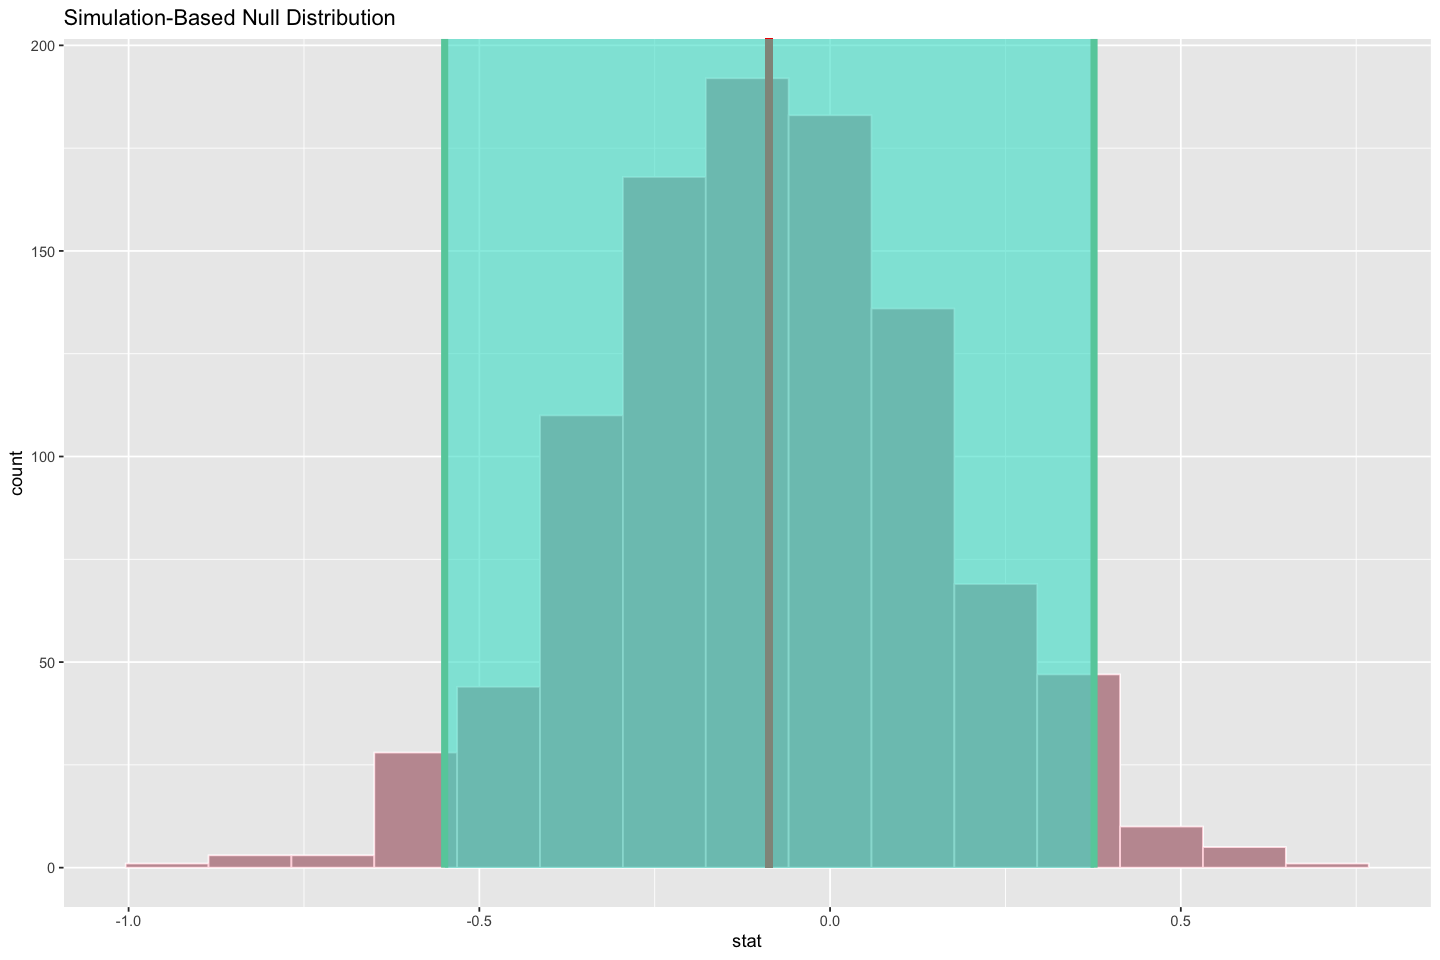

In [14]:
set.seed(42069)

combined_sample <- bind_rows(summer_sample, winter_sample)

null_distribution <- combined_sample %>%
    specify(Age ~ Season) %>%
    hypothesise("independence") %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("Summer", "Winter"))

obs_diff_mean <- combined_sample %>%
    specify(Age ~ Season) %>%
    calculate(stat = "diff in means", order = c("Summer", "Winter"))

percentile_ci <- null_distribution %>%
    get_confidence_interval(level = 0.95, type = "percentile")

print(paste0("P-value = ", get_p_value(null_distribution,
                                       obs_stat = obs_diff_mean,
                                       direction = "both")))
                                       
percentile_ci
visualize(null_distribution) +
shade_p_value(obs_diff_mean, "both") + # the red vertical line
shade_ci(endpoints = percentile_ci) # the blue box

# References

Apollaro, G., Rodríguez, Y. Q., Herrera-Valenzuela, T., Hernández-Mendo, A., & Falcó, C. (2022, January 27). Relative and chronological age in successful athletes at the World Taekwondo Championships (1997–2019): A focus on the behaviour of multiple medallists. MDPI. Retrieved March 1, 2022, from https://doi.org/10.3390/ijerph19031425 

Ford, P. R., & Williams, M. A. (2013, January 23). No relative age effect in the birth dates of award-winning athletes in male professional team sports. Taylor & Francis. Retrieved March 1, 2022, from https://www.tandfonline.com/doi/abs/10.1080/02701367.2011.10599790 

John Horne, G. W. (2016, May 26). Understanding the Olympics: Second edition. Taylor & Francis. Retrieved March 1, 2022, from https://www.taylorfrancis.com/books/mono/10.4324/9781315712529/understanding-olympics-john-horne-garry-whannel 